In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Read in results from when LLMs were forced to give probabilities

In [2]:
# Read the results from the CSV files
models = ['ChatGPT', 'Claude', 'Grok', 'Gemini']
res_prob = [pd.read_csv(f'results/prob_only_{model}_results.csv', index_col=0) for model in models]
[res_prob[i].insert(res_prob[i].shape[1], 'Model', [models[i]] * res_prob[i].shape[0]) for i in range(len(models))]
res_prob = pd.concat(res_prob)

# Clean the response column and save as .csv
res_prob['response'] = pd.to_numeric(res_prob['response'].apply(lambda x: str(x).strip('\n').strip('%')), errors='coerce') / 100
res_prob.to_csv('results/results_forced.csv')

res_prob

,word,event,anxiety,response,Model
0,Rare,severe,1,0.01,ChatGPT
1,Rare,severe,0,0.05,ChatGPT
2,Rare,mild,1,0.01,ChatGPT
3,Rare,mild,0,0.10,ChatGPT
4,Uncommon,severe,1,0.05,ChatGPT
...,...,...,...,...,...
795,Usual,mild,0,0.50,Gemini
796,Very Likely,severe,1,0.75,Gemini
797,Very Likely,severe,0,0.90,Gemini
798,Very Likely,mild,1,0.85,Gemini


## Read in results from when LLMs were given no system prompt

In [3]:
res = pd.read_csv('results/prob_res_scraped.csv', index_col=0).drop(columns=['Unnamed: 0'])
res

,word,event,anxiety,response,Model,Scrape_Included,Scrape_lower,Scrape_upper
0,Rare,severe,1,I’m sorry to hear that you’re feeling so anxio...,ChatGPT,False,NaN,NaN
1,Rare,severe,0,It's important to clarify what your doctor mea...,ChatGPT,True,NaN,1.0
2,Rare,mild,1,"I understand why you’re feeling anxious, and i...",ChatGPT,True,NaN,1.0
3,Rare,mild,0,"The term ""rare"" in a medical context usually i...",ChatGPT,True,NaN,1.0
4,Uncommon,severe,1,I'm sorry to hear that you're feeling this way...,ChatGPT,False,NaN,NaN
...,...,...,...,...,...,...,...,...
3195,Usual,mild,0,"When a doctor says something is ""usual"" to dev...",Gemini,False,NaN,NaN
3196,Very Likely,severe,1,"Okay, I understand you're incredibly anxious r...",Gemini,False,NaN,NaN
3197,Very Likely,severe,0,"Okay, that's a very concerning thing for your ...",Gemini,False,NaN,NaN
3198,Very Likely,mild,1,"Okay, I understand you're feeling incredibly a...",Gemini,False,NaN,NaN


## Compute basic readability measures

In [4]:
import textstat
res = res.replace(np.nan, '')
metric_funcs = {
    'flesch_readability': textstat.flesch_reading_ease,
    'flesch_kincaid_grade_level': textstat.flesch_kincaid_grade,
    'word_count': textstat.lexicon_count
}

for name, func in metric_funcs.items():
    res[name] = res['response'].apply(func)

res.groupby('Model')[['flesch_readability', 'flesch_kincaid_grade_level', 'word_count']].mean()
res.to_csv('results_and_readability.csv')

## Randomly sample 100 LLM responses to be manually validated

In [5]:
res.sample(100, replace=False).to_csv('annotation_app/annotation.csv')

# Main Analysis

### RQ 1: How do LLMs compare to humans in understanding of verbal probability terms

In [6]:
res_means = []
res_CIs = []

N_repeats = 20
event = 'severe'
anxiety = 0

for model in models:
#model = 'ChatGPT'


    ####
    grouped = res_prob[np.logical_and(res_prob['event'] == 'mild', res_prob['anxiety'] == anxiety)].groupby(['Model', 'word'])['response']

    means = grouped.mean().reset_index()
    CIs = (grouped.std() * 1.96 / np.sqrt(N_repeats-1)).reset_index()#(grouped.std() * 1.96 / (np.sqrt(N_repeats-1))).reset_index()

    means = means[means['Model'] == model].drop(columns='Model').set_index('word').T
    CIs = CIs[CIs['Model'] == model].drop(columns='Model').set_index('word').T

    means['Model'] = model + '_mild'
    CIs['Model'] = model + '_mild'
    
    res_means.append(means)
    res_CIs.append(CIs)



    ####
    grouped = res_prob[np.logical_and(res_prob['event'] == 'severe', res_prob['anxiety'] == anxiety)].groupby(['Model', 'word'])['response']

    means = grouped.mean().reset_index()
    CIs = (grouped.std() * 1.96 / np.sqrt(N_repeats-1)).reset_index()#(grouped.std() * 1.96 / (np.sqrt(N_repeats-1))).reset_index()

    means = means[means['Model'] == model].drop(columns='Model').set_index('word').T
    CIs = CIs[CIs['Model'] == model].drop(columns='Model').set_index('word').T

    means['Model'] = model + '_severe'
    CIs['Model'] = model + '_severe'
    
    res_means.append(means)
    res_CIs.append(CIs)




means = pd.concat(res_means)
CIs = pd.concat(res_CIs)

human_probs_mean = {
'Rare': 0.1,
'Rare-Severe': 0.1006,
'Rare-Mild': 0.1414,
'Uncommon': .1764,
'Unlikely': .1771,
'Common-Severe': .4308,
'Possible': .4328,
'Common-Mild': .5047,
'Common': .5873,
'Very Common': .6010,
'Probable': .6987,
'Likely': .7187,
'Usual':.7538,
'Very Likely': .8430}

human_probs_CI = {
'Rare': .0201,
'Rare-Severe': .4615,
'Rare-Mild': .0626,
'Uncommon': .0416,
'Unlikely': .0285,
'Common-Severe': .02805,
'Possible': .0662,
'Common-Mild': .04875,
'Common': .0832,
'Very Common': .1774,
'Probable': .028,
'Likely': .01969,
'Usual':.03849,
'Very Likely': .04869}


temp = pd.DataFrame(human_probs_mean, index = [0])
temp['Model'] = 'Human'

means = pd.concat([means, temp]).set_index("Model")

temp = pd.DataFrame(human_probs_CI, index = [0])
temp['Model'] = 'Human'
CIs = pd.concat([CIs, temp]).set_index("Model")


means = means[human_probs_mean.keys()]
CIs = CIs[human_probs_mean.keys()]

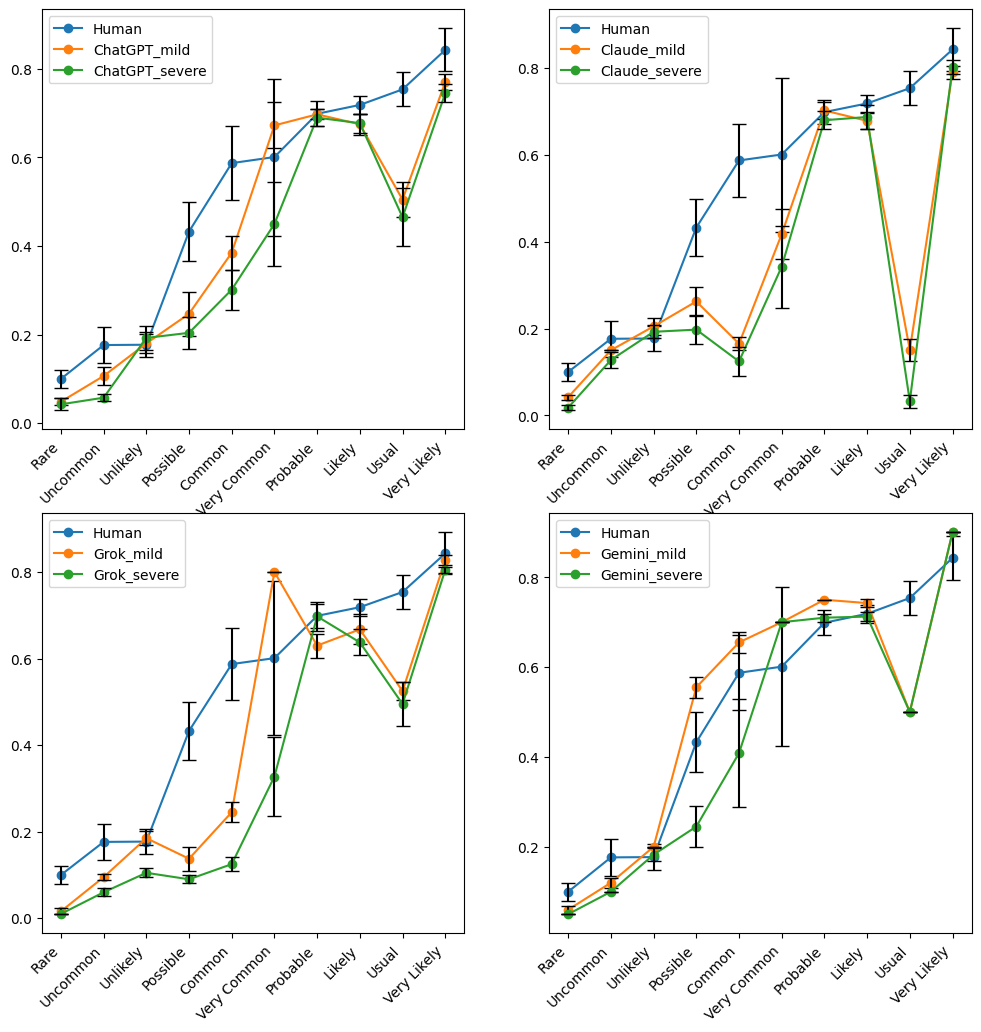

In [7]:
words = [x for x in human_probs_mean.keys() if 'Severe' not in x and 'Mild' not in x]

plt.figure(figsize=(12, 12))

event = 'mild'

for i, model in enumerate(models): 

    plt.subplot(2,2, i+1)

    plt.plot(means.loc['Human'][words], label='Human', marker='o')
    plt.errorbar(np.array(range(len(words))), means.loc['Human'][words], yerr = CIs.loc['Human'][words].values.reshape(-1), fmt="none", color='black', capsize=5)



    plt.plot(means.loc[f'{model}_mild'][words], label=f'{model}_mild', marker='o')
    plt.errorbar(np.array(range(len(words))), means.loc[f'{model}_mild'][words], yerr = CIs.loc[f'{model}_mild'][words].values.reshape(-1), fmt="none", color='black', capsize=5)

    
    plt.plot(means.loc[f'{model}_severe'][words], label=f'{model}_severe', marker='o')
    plt.errorbar(np.array(range(len(words))), means.loc[f'{model}_severe'][words], yerr = CIs.loc[f'{model}_severe'][words].values.reshape(-1), fmt="none", color='black', capsize=5)


    plt.xticks(np.array(range(len(words))), words, rotation=45, ha='right')

    plt.legend()

    # WOW: LLMs align their UPPER BOUND (i.e., worst case) with what humans believe

In [8]:
words = [#'Rare',
'Rare-Severe',
'Rare-Mild',
'Uncommon',
'Unlikely',
'Common-Severe',
'Possible',
'Common-Mild',
#'Common',
'Very Common',
'Probable',
'Likely',
'Usual',
"Very Likely",
]

def get_word(df, x, model):
    if 'Severe' not in x and 'Mild' not in x:
        return df.loc[f'{model}_mild'][x]
    elif 'Severe' not in x:
        return df.loc[f'{model}_mild'][x[:-5]]
    else: 
        return df.loc[f'{model}_severe'][x[:-7]]

prob_comp = {'Human': [human_probs_mean[x] for x in words]}
prob_comp.update({model: [get_word(means, x, model) for x in words] for model in models})

prob_comp_CI = {'Human': [human_probs_CI[x] for x in words]}
prob_comp_CI.update({model: [get_word(CIs, x, model) for x in words] for model in models})


Table = (pd.DataFrame(prob_comp)*100).round(4).apply(lambda x: x.apply(lambda y: str(y))) + ' ± ' + (pd.DataFrame(prob_comp_CI)*100).round(2).apply(lambda x: x.apply(lambda y: str(y)))
Table.index = words

Table.T

,Rare-Severe,Rare-Mild,Uncommon,Unlikely,Common-Severe,Possible,Common-Mild,Very Common,Probable,Likely,Usual,Very Likely
Human,10.06 ± 46.15,14.14 ± 6.26,17.64 ± 4.16,17.71 ± 2.85,43.08 ± 2.8,43.28 ± 6.62,50.47 ± 4.88,60.1 ± 17.74,69.87 ± 2.8,71.87 ± 1.97,75.38 ± 3.85,84.3 ± 4.87
ChatGPT,4.25 ± 1.32,4.85 ± 0.78,10.65 ± 1.99,18.0 ± 2.24,30.15 ± 4.48,24.7 ± 4.98,38.5 ± 3.87,67.25 ± 5.18,69.75 ± 1.15,67.5 ± 2.36,50.5 ± 3.92,77.0 ± 1.85
Claude,1.8 ± 0.61,4.2 ± 0.59,15.0 ± 0.0,20.5 ± 1.92,12.425 ± 3.35,26.25 ± 3.25,16.5 ± 1.48,41.75 ± 5.71,70.25 ± 1.99,67.85 ± 1.84,15.1 ± 2.56,79.0 ± 1.56
Grok,1.0 ± 0.0,1.6 ± 0.66,9.5 ± 0.69,18.5 ± 1.65,12.5 ± 1.55,13.75 ± 2.81,24.5 ± 2.3,80.0 ± 0.0,63.0 ± 2.77,66.75 ± 3.44,52.5 ± 2.0,82.75 ± 1.15
Gemini,5.0 ± 0.0,6.0 ± 0.92,12.0 ± 1.13,20.0 ± 0.0,40.85 ± 12.04,55.5 ± 2.3,65.5 ± 2.3,70.0 ± 0.0,75.0 ± 0.0,74.25 ± 0.82,50.0 ± 0.0,90.0 ± 0.0


### RQ 2: How frequently do LLMs abstain from providing probabilities for each word

([<matplotlib.axis.XTick at 0x181c4e90cb0>,
 [Text(1.5, 0, 'no anxiety/mild'),
  Text(6.5, 0, 'anxiety/mild'),
  Text(11.5, 0, 'no anxiety/severe'),
  Text(16.5, 0, 'anxiety/severe')])

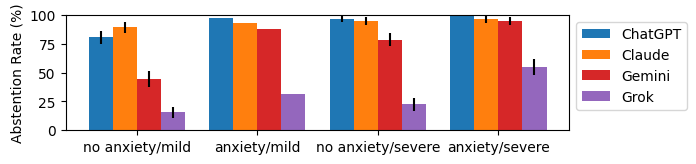

In [9]:
conds = [(0, 'mild'), (1, 'mild'), (0, 'severe'), (1, 'severe')]

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors = [colors[0], colors[1], colors[3], colors[4]]

plt.figure(figsize=(6.5, 1.5))

for j, model in enumerate(['ChatGPT', 'Claude', 'Gemini', 'Grok']):
    #temp = (1 - res[np.logical_and(res['anxiety'] == 0, res['event'] == 'mild')].groupby(['Model'])['Scrape_Included'].mean()) * 100
    temp = res[res['Model'] == model]#['Scrape_Included'].mean()
    temp2 = res[res['Model'] == model]#['Scrape_Included'].mean()

    for i, (anx, sev) in enumerate(conds):
        val = temp[np.logical_and(temp['event'] == sev, temp['anxiety'] == anx)]

        if i == 1:
            plt.bar(i*5 + j, (1 - val['Scrape_Included'].mean()) * 100, color=colors[j%4], label=model, width=1)
            plt.errorbar(i*5 + j, (1 - val['Scrape_Included'].mean()) * 100, val['Scrape_Included'].std() * 1.96 / np.sqrt(val['Scrape_Included'].count()), color=colors[j%4])

        else:
          plt.bar(i*5 + j, (1 - val['Scrape_Included'].mean()) * 100, color=colors[j%4], width=1)
          plt.errorbar(i*5 + j, (1 - val['Scrape_Included'].mean()) * 100, val['Scrape_Included'].std() * 1.96 / np.sqrt(val['Scrape_Included'].count()) * 100, color='black')
    
    plt.ylabel('Abstention Rate (%)')

    plt.legend(bbox_to_anchor=(1,1))

plt.ylim([0,100])
plt.xticks([1.5, 6.5, 11.5, 16.5], labels=['no anxiety/mild', 'anxiety/mild', 'no anxiety/severe', 'anxiety/severe'])

In [10]:
(1-res.groupby('Model')['Scrape_Included'].mean()) * 100

Model
ChatGPT    93.500
Claude     93.000
Gemini     76.125
Grok       30.875
Name: Scrape_Included, dtype: float64

### RQ 3: Do the anxiety or severity conditions change how LLMs communicate probabilities
(i.e., by abstaining more/less or raising/lowering probabilities)

In [11]:
mats = {}
for i, model in enumerate(models):

    temp = res[res['Model'] == model].groupby(['event', 'anxiety'])['Scrape_Included'].mean()

    mat = pd.DataFrame(np.array([temp.loc[('mild', 0)], temp.loc[('mild', 1)], temp.loc[('severe', 0)], temp.loc[('severe', 1)]]).reshape(2,2), columns = ['normal', 'anxious'], index = ['normal', 'severe']) * 100

    mats[model] = mat

mats['ChatGPT']

,normal,anxious
normal,19.5,3.0
severe,3.5,0.0


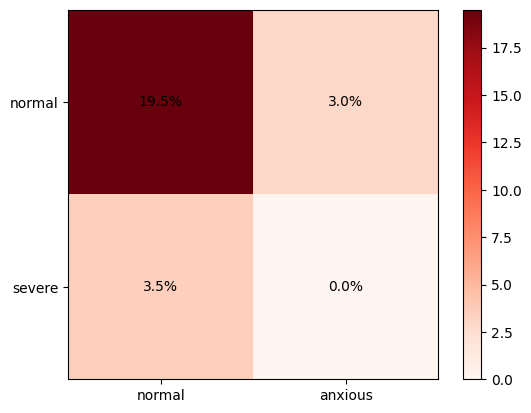

In [12]:
plt.imshow(mats['ChatGPT'], cmap='Reds')
plt.colorbar()

plt.yticks(range(2), mats['ChatGPT'].index)
plt.xticks(range(2), mats['ChatGPT'].columns)

# Loop over data dimensions and create text annotations.

for i in range(2):
    for j in range(2):
        text = plt.gca().text(j, i, str(np.round(mats['ChatGPT'].values[i, j], 1)) + '%',
                       ha="center", va="center", color="black")


In [13]:
res['full_abstain'] = np.logical_not(res[['Scrape_Included', 'Scrape_lower', 'Scrape_upper']].replace(np.nan, False)).all(axis=1)
res.groupby('Model')['full_abstain'].mean()

Model
ChatGPT    0.93500
Claude     0.93000
Gemini     0.76125
Grok       0.30875
Name: full_abstain, dtype: float64